Data Preprocessing

Import Libaries and dataset

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [7]:
# Load original datasets
df_trn = pd.read_excel("ArTrnDetails_2023.xlsx")
df_trn.head()

,Year,Month,Register,Invoice,SummaryLine,DetailLine,InvoiceDate,Branch,Salesperson,Customer,...,WarehouseAccount,WhAnalysisEntry,WarehouseAmount,TaxAccount,GlIntLevel,TimeStamp,PriceGroup,PriceGroupRule,DimensionEntry,DimensionLine
0,2023,1,1,10000001,1,1,2023-01-04,CTRD,SM-JL,CTRD-B0007,...,,0,0,,D,0x0000000004AF4A06,,0,0,0
1,2023,1,1,10000001,1,2,2023-01-04,CTRD,SM-JL,CTRD-B0007,...,,0,0,,D,0x0000000004AF4A07,,0,0,0
2,2023,1,2,10000002,1,1,2023-01-04,CTRD,SM-SC,CTRD-M0042,...,,0,0,,D,0x0000000004AF4A08,,0,0,0
3,2023,1,2,10000002,1,2,2023-01-04,CTRD,SM-SC,CTRD-M0042,...,,0,0,,D,0x0000000004AF4A09,,0,0,0
4,2023,1,2,10000002,1,3,2023-01-04,CTRD,SM-SC,CTRD-M0042,...,,0,0,,D,0x0000000004AF4A0A,,0,0,0


In [12]:
#Show all column names
print(df_trn.columns.tolist())

['Year', 'Month', 'Register', 'Invoice', 'SummaryLine', 'DetailLine', 'InvoiceDate', 'Branch', 'Salesperson', 'Customer', 'OrderType', 'InterBranchTrf', 'StockCode', 'Warehouse', 'Area', 'ProductClass', 'TaxCode', 'TaxStatus', 'HistoryReqd', 'CustomerClass', 'QtyInvoiced', 'Mass', 'Volume', 'NetSalesValue', 'TaxValue', 'CostValue', 'DiscValue', 'LineType', 'PriceCode', 'DocumentType', 'ProductClassUpd', 'GlDistrUpd', 'SalespersonUpd', 'SalesGlIntReqd', 'StockUpd', 'InterfaceFlag', 'GlYear', 'GlPeriod', 'SalesTurnOPrted', 'TaxCodeFst', 'TaxValueFst', 'SalesOrder', 'ContractPrcNum', 'Bin', 'LineInvoiceDisc', 'UserField1', 'UserField2', 'TaxableValue', 'CustomerPoNumber', 'AbcUpd', 'BuyingGroup', 'PostValue', 'PostCurrency', 'PostConvRate', 'PostMulDiv', 'AccountCur', 'AccountConvRate', 'AccountMulDiv', 'TriangCurrency', 'TriangConvRate', 'TriangMulDiv', 'Version', 'Release', 'EecInvoiceFlag', 'Nationality', 'SalesOrderLine', 'TransactionGlCode', 'DiscountGlCode', 'CostGlCode', 'GlIntUpda

In [20]:
# Show number of rows and columns
print(f" Number of rows: {df_trn.shape[0]}")
print(f" Number of columns: {df_trn.shape[1]}")

 Number of rows: 59041
 Number of columns: 88


In [22]:
df_target = pd.read_excel("SalesTarget2023.xlsx")
df_target.head()

,Salesperson,ProductClass,Month,Year,Target
0,HQ,FG,1,2023,3500.0
1,SM-SH,FG,1,2023,48750.0
2,SM-JL,FG,1,2023,110000.0
3,SM-SC,FG,1,2023,110500.0
4,SM-JW,FG,1,2023,350000.0


In [24]:
# Show number of rows and columns
print(f" Number of rows: {df_target.shape[0]}")
print(f" Number of columns: {df_target.shape[1]}")

 Number of rows: 454
 Number of columns: 5


Column Subset Selection

In [2]:
cols_to_keep = [
    'CustomerClass',
    'Salesperson', 'ProductClass',
    'Invoice',
    'Month', 'Year',
    'QtyInvoiced', 'NetSalesValue'
]

df_clean = df_trn[cols_to_keep].copy()


Data Normalization

In [3]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # strings to uppercase/trim
    for c in ['CustomerClass','Salesperson','ProductClass']:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.upper()
    # Month can be number or name; coerce to 1..12 Int64
    if 'Month' in df.columns:
        m_raw = df['Month'].astype(str).str.strip()
        month_num = pd.to_numeric(m_raw, errors='coerce')
        month_map = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
                     'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
        month_name = m_raw.str[:3].str.upper().map(month_map)
        df['Month'] = month_num.fillna(month_name).astype('Int64')
    if 'Year' in df.columns:
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    # numerics
    for c in ['QtyInvoiced','NetSalesValue']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    if 'Invoice' in df.columns:
        df['Invoice'] = df['Invoice'].astype(str).str.strip()
    return df

df_clean  = normalize(df_clean)
df_target = normalize(df_target)

# Standardize target column name if needed
if 'TargetSales' not in df_target.columns:
    for alt in ['SalesTarget','Target','Target_Sales','Sales_Target']:
        if alt in df_target.columns:
            df_target = df_target.rename(columns={alt: 'TargetSales'})
            break
if 'TargetSales' not in df_target.columns:
    raise ValueError("Target column not found in SalesTarget2023.xlsx (expected 'TargetSales').")

Joining Target data to the Transactions data

In [4]:
keys = ['Salesperson','ProductClass','Month','Year']

# ensure one target row per key (use median if duplicates exist)
df_target_unique = (
    df_target.dropna(subset=keys + ['TargetSales'])
             .groupby(keys, as_index=False)['TargetSales'].median()
)


In [5]:
df_line = df_clean.merge(
    df_target_unique,
    on=keys,
    how='left',
    validate='m:1'   # many line-items to one target
)

print(f"Line-items kept: {len(df_line):,}")
print("Matched targets before fill:", df_line['TargetSales'].notna().sum())


Line-items kept: 59,041
Matched targets before fill: 43723


In [6]:
df_line['TargetSales'] = pd.to_numeric(df_line['TargetSales'], errors='coerce')

# a) by (Salesperson, ProductClass)
sp_pc_med = df_line.groupby(['Salesperson','ProductClass'])['TargetSales'].transform('median')
df_line['TargetSales'] = df_line['TargetSales'].fillna(sp_pc_med)

# b) by Salesperson
sp_med = df_line.groupby('Salesperson')['TargetSales'].transform('median')
df_line['TargetSales'] = df_line['TargetSales'].fillna(sp_med)

# c) by ProductClass
pc_med = df_line.groupby('ProductClass')['TargetSales'].transform('median')
df_line['TargetSales'] = df_line['TargetSales'].fillna(pc_med)

# d) by Month (seasonality fallback)
mon_med = df_line.groupby('Month')['TargetSales'].transform('median')
df_line['TargetSales'] = df_line['TargetSales'].fillna(mon_med)

# e) global median
global_med = df_line['TargetSales'].median()
df_line['TargetSales'] = df_line['TargetSales'].fillna(global_med)

print("Missing targets after fill:", df_line['TargetSales'].isna().sum())

Missing targets after fill: 0


In [7]:
# Make sure TargetSales is numeric
df_line['TargetSales'] = pd.to_numeric(df_line['TargetSales'], errors='coerce')

# 1) Long list: unique (Salesperson, ProductClass, TargetSales) rows
out_long = (
    df_line[['Salesperson','ProductClass','TargetSales']]
      .dropna(subset=['TargetSales'])
      .drop_duplicates()
      .sort_values(['Salesperson','ProductClass','TargetSales'])
)
display(out_long)

# 2) One row per (Salesperson, ProductClass): median TargetSales across months
out_median = (
    df_line.groupby(['Salesperson','ProductClass'], as_index=False)['TargetSales']
           .median()
           .rename(columns={'TargetSales':'TargetSales_Median'})
           .sort_values(['Salesperson','ProductClass'])
)
display(out_median)



,Salesperson,ProductClass,TargetSales
2475,D&Q,GB,277336.606400
40952,D&Q,_AR AP CONTRA,276849.201800
9543,D&Q,_MISC.INC,1505.281818
4807,ECOM-DEGAYO,FG,110000.000000
14147,ECOM-DEGAYO,_ECOM,17933.316360
...,...,...,...
3826,SM-SH,TEA,8744.600000
42509,SM-SH,TEA,9027.400000
53917,SM-SH,TEA,9436.000000
58746,SM-SH,_DEP,277336.606400


,Salesperson,ProductClass,TargetSales_Median
0,D&Q,GB,277336.606400
1,D&Q,_AR AP CONTRA,276849.201800
2,D&Q,_MISC.INC,1505.281818
3,ECOM-DEGAYO,FG,110000.000000
4,ECOM-DEGAYO,_ECOM,17933.316360
...,...,...,...
151,SM-SH,SERV,277336.606400
152,SM-SH,SP,277336.606400
153,SM-SH,TEA,6366.400000
154,SM-SH,_DEP,277336.606400


Product Class Filtering and Pareto Analysis

In [14]:
import pandas as pd

# Choose the widest table available
if 'df_line' in globals():
    base = df_line
elif 'df_clean' in globals():
    base = df_clean
else:
    base = df_trn  # raw transactions as last resort

# Ensure the column exists
assert 'ProductClass' in base.columns, "ProductClass column not found."

# Unique, sorted list (already uppercased in earlier steps; keep for safety)
product_classes = (base['ProductClass']
                   .astype(str).str.strip().str.upper()
                   .dropna().drop_duplicates()
                   .sort_values())

# Show as a DataFrame
df_product_list = pd.DataFrame({'ProductClass': product_classes.values})

print(f"Total unique ProductClass: {len(df_product_list)}")
display(df_product_list)

# Optional: also show frequency (how many line-items per ProductClass)
df_pc_counts = (base['ProductClass']
                .astype(str).str.strip().str.upper()
                .value_counts()
                .rename_axis('ProductClass').reset_index(name='LineItems'))



Total unique ProductClass: 27


,ProductClass
0,A&P EXPENSE
1,ACC
2,BAD DEBTS
3,BBX
4,CHOCB
5,CHOCP
6,CM
7,CMR
8,DVG
9,FG


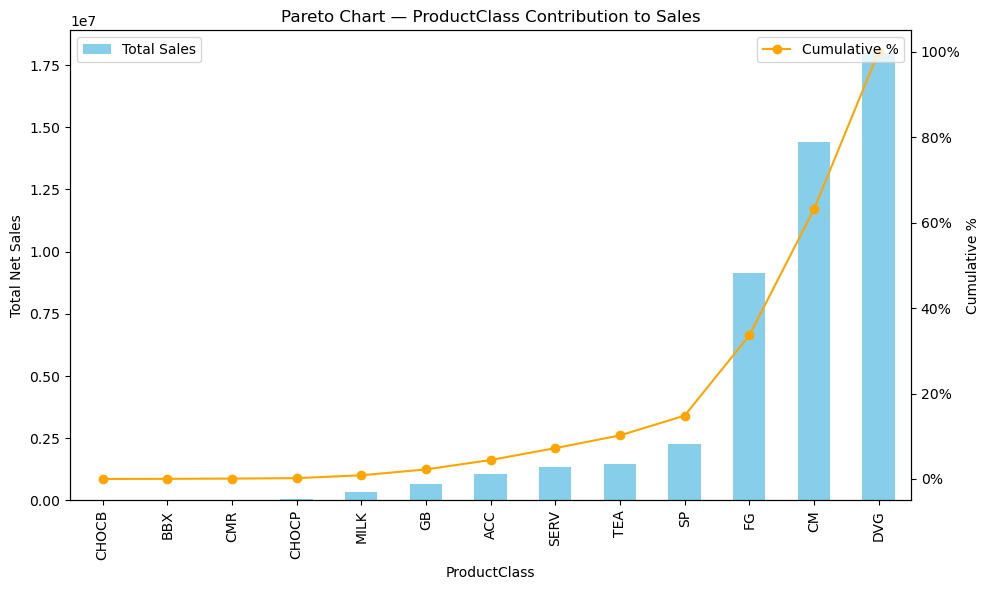

In [100]:
import matplotlib.pyplot as plt

pc_sales = df_line.groupby('ProductClass')['NetSalesValue'].sum().sort_values()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

pc_sales.plot(
    kind='bar',
    ax=ax1,
    color='skyblue',
    label='Total Sales'
)

# Properly compute and plot cumulative percentage
pct = pc_sales.cumsum() / pc_sales.sum() * 100  # ensures a Series
pct.plot(
    ax=ax2,
    color='orange',
    marker='o',
    label='Cumulative %'
)

ax1.set_ylabel('Total Net Sales')
ax2.set_ylabel('Cumulative %')
ax2.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter())

ax1.set_title('Pareto Chart — ProductClass Contribution to Sales')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [9]:
# --- Keep only these ProductClass values ------------------------------------
KEEP_PC = ['ACC','BBX','CHOCB','CHOCP','CM','CMR','DVG','FG','GB','MILK','SP','TEA','SERV']
KEEP_PC = {x.strip().upper() for x in KEEP_PC}  # to a set for speed/safety

before = len(df_line)
mask = df_line['ProductClass'].astype(str).str.strip().str.upper().isin(KEEP_PC)
df_line = df_line.loc[mask].copy()
after = len(df_line)

print(f"Rows before filter: {before:,}")
print(f"Rows after  filter: {after:,}  (kept {(after/before):.1%})")

# Verify what remains
remaining = (df_line['ProductClass']
             .astype(str).str.strip().str.upper()
             .drop_duplicates().sort_values())
print(f"Unique ProductClass kept: {len(remaining)}")
print(remaining.tolist())


Rows before filter: 59,041
Rows after  filter: 57,214  (kept 96.9%)
Unique ProductClass kept: 13
['ACC', 'BBX', 'CHOCB', 'CHOCP', 'CM', 'CMR', 'DVG', 'FG', 'GB', 'MILK', 'SERV', 'SP', 'TEA']


In [10]:
na_summary = (
    base.isna().sum().to_frame('MissingCount')
        .assign(TotalRows=len(base))
        .assign(MissingPct=lambda d: (d['MissingCount']/d['TotalRows']*100).round(2))
        .sort_values('MissingCount', ascending=False)
)
display(na_summary[na_summary['MissingCount'] > 0])

,MissingCount,TotalRows,MissingPct


In [11]:
key_cols = ['Salesperson','ProductClass','Month','Year',
            'Invoice','QtyInvoiced','NetSalesValue','TargetSales']

key_na = (
    base[key_cols].isna().sum().to_frame('MissingCount')
        .assign(MissingPct=lambda d: (d['MissingCount']/len(base)*100).round(2))
        .sort_values('MissingCount', ascending=False)
)
print("\nMissing in key columns:")
display(key_na)

# How many rows have ANY missing among key columns?
miss_mask = base[key_cols].isna().any(axis=1)
print(f"Rows with any missing in key cols: {miss_mask.sum():,} / {len(base):,}")

# Peek a few problematic rows
display(base.loc[miss_mask, key_cols + (['CustomerClass'] if 'CustomerClass' in base.columns else [])].head(20))



Missing in key columns:


,MissingCount,MissingPct
Salesperson,0,0.0
ProductClass,0,0.0
Month,0,0.0
Year,0,0.0
Invoice,0,0.0
QtyInvoiced,0,0.0
NetSalesValue,0,0.0
TargetSales,0,0.0


Rows with any missing in key cols: 0 / 59,041


,Salesperson,ProductClass,Month,Year,Invoice,QtyInvoiced,NetSalesValue,TargetSales,CustomerClass


In [12]:
# Row count after your whitelist + fills
print("Current rows:", len(df_line))
print("Unique ProductClass:", df_line['ProductClass'].nunique())

# 1) Ensure one TargetSales per (Salesperson, ProductClass, Month, Year)
keys = ['Salesperson','ProductClass','Month','Year']
dupes = (df_line.groupby(keys)['TargetSales']
               .nunique().reset_index(name='n_unique_target'))
print("Keys with >1 distinct TargetSales:", (dupes['n_unique_target'] > 1).sum())
display(dupes[dupes['n_unique_target'] > 1].head())

# 2) Check for negative/zero numeric anomalies
print("Negative QtyInvoiced:", (df_line['QtyInvoiced'] < 0).sum())
print("Negative NetSalesValue:", (df_line['NetSalesValue'] < 0).sum())
print("Zero TargetSales rows:", (df_line['TargetSales'] == 0).sum())

# 3) Quick TargetSales distribution (overall and by Salesperson×ProductClass)
print(df_line['TargetSales'].describe())

ts_stats = (df_line.groupby(['Salesperson','ProductClass'])['TargetSales']
                    .agg(['count','median','min','max'])
                    .reset_index()
                    .sort_values(['Salesperson','ProductClass']))
display(ts_stats.head(20))


Current rows: 57214
Unique ProductClass: 13
Keys with >1 distinct TargetSales: 0


,Salesperson,ProductClass,Month,Year,n_unique_target


Negative QtyInvoiced: 1009
Negative NetSalesValue: 956
Zero TargetSales rows: 0
count     57214.000000
mean     214369.903710
std      151668.279023
min          35.000000
25%       33213.750000
50%      276849.201800
75%      334839.470900
max      439733.333300
Name: TargetSales, dtype: float64


,Salesperson,ProductClass,count,median,min,max
0,D&Q,GB,20,277336.606400,277336.606400,277336.606400
1,ECOM-DEGAYO,FG,118,110000.000000,110000.000000,110000.000000
2,ECOM-GCR,ACC,16,6315.718182,6315.718182,6315.718182
3,ECOM-GCR,CM,9,4856.666667,4856.666667,4856.666667
4,ECOM-GCR,DVG,700,6315.718182,6315.718182,6315.720000
5,ECOM-GCR,FG,260,6315.718182,6315.718182,6315.718182
6,ECOM-GCR,MILK,14,6315.718182,6315.718182,6315.718182
7,ECOM-GCR,SERV,3,6315.718182,6315.718182,6315.718182
8,ECOM-GCR,SP,9,6315.718182,6315.718182,6315.718182
9,ECOM-GCR,TEA,25,895.000000,120.000000,1048.800000


In [13]:
import pandas as pd

# ensure Month is numeric 1..12
df_line['Month'] = pd.to_numeric(df_line['Month'], errors='coerce').astype('Int64')

ALL_MONTHS = list(range(1, 13))
ABBR = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

def fmt(ms):
    ms = [int(m) for m in ms if pd.notna(m)]
    return ', '.join(ABBR[m-1] for m in sorted(ms)) if ms else ''

def missing(ms):
    ms = set(int(m) for m in ms if pd.notna(m))
    miss = [m for m in ALL_MONTHS if m not in ms]
    return ', '.join(ABBR[m-1] for m in miss)

months_list = (
    df_line.dropna(subset=['Month'])
           .groupby(['Salesperson','ProductClass'])['Month']
           .apply(lambda s: sorted(s.unique().tolist()))
           .reset_index(name='MonthsAvailable')
)

months_list['NumMonths']         = months_list['MonthsAvailable'].apply(len)
months_list['MonthsAvailableStr']= months_list['MonthsAvailable'].apply(fmt)
months_list['MissingMonthsStr']  = months_list['MonthsAvailable'].apply(missing)

out_list = months_list[['Salesperson','ProductClass','NumMonths','MonthsAvailableStr','MissingMonthsStr']]\
            .sort_values(['Salesperson','ProductClass'])
display(out_list)

# Optional: save
# out_list.to_csv("months_by_salesperson_productclass.csv", index=False)


,Salesperson,ProductClass,NumMonths,MonthsAvailableStr,MissingMonthsStr
0,D&Q,GB,12,"JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG, SEP, O...",
1,ECOM-DEGAYO,FG,11,"FEB, MAR, APR, MAY, JUN, JUL, AUG, SEP, OCT, N...",JAN
2,ECOM-GCR,ACC,7,"JAN, MAR, MAY, AUG, OCT, NOV, DEC","FEB, APR, JUN, JUL, SEP"
3,ECOM-GCR,CM,5,"MAY, JUN, AUG, SEP, NOV","JAN, FEB, MAR, APR, JUL, OCT, DEC"
4,ECOM-GCR,DVG,12,"JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG, SEP, O...",
...,...,...,...,...,...
102,SM-SH,GB,5,"AUG, SEP, OCT, NOV, DEC","JAN, FEB, MAR, APR, MAY, JUN, JUL"
103,SM-SH,MILK,12,"JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG, SEP, O...",
104,SM-SH,SERV,12,"JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG, SEP, O...",
105,SM-SH,SP,12,"JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG, SEP, O...",


In [14]:
import numpy as np
import pandas as pd

# ---------------- 0) Prep: positive-only monthly aggregates -----------------
# If you already created these columns earlier, this will just overwrite with same values
df_line['QtyInvoiced_pos']   = df_line['QtyInvoiced'].clip(lower=0)
df_line['NetSalesValue_pos'] = df_line['NetSalesValue'].clip(lower=0)

keys = ['Salesperson','ProductClass','Year','Month']
df_month = (
    df_line.groupby(keys, as_index=False)
           .agg(
               QtyInvoiced=('QtyInvoiced_pos','sum'),
               NetSalesValue=('NetSalesValue_pos','sum'),
               NumInvoices=('Invoice','nunique'),
               TargetSales=('TargetSales','median')  # monthly target
           )
)

# ---------------- 1) Create full 12-month grid per SP×PC×Year ---------------
ALL_MONTHS = pd.DataFrame({'Month': list(range(1,13))})
base_keys = df_month[['Salesperson','ProductClass','Year']].drop_duplicates()
base_keys['key']=1; ALL_MONTHS['key']=1
full_grid = (base_keys.merge(ALL_MONTHS, on='key').drop(columns='key'))

# left-merge existing monthly rows into the full grid (so missing months become NaN)
full = (full_grid.merge(df_month, on=keys, how='left'))

# ---------------- 2) Median fallback + jitter imputation --------------------
rng = np.random.default_rng(42)   # change seed if you want different randomization
JITTER_PCT = 0.12                 # ±12% jitter; tweak to taste

def add_medians(df_src, col):
    """Attach median fallback columns for a given metric."""
    m1 = df_src.groupby(['Salesperson','ProductClass','Year'])[col].median().reset_index().rename(columns={col:'m1'})
    m2 = df_src.groupby(['Salesperson','ProductClass'])[col].median().reset_index().rename(columns={col:'m2'})
    m3 = df_src.groupby(['Salesperson'])[col].median().reset_index().rename(columns={col:'m3'})
    m4 = df_src.groupby(['ProductClass'])[col].median().reset_index().rename(columns={col:'m4'})
    m5 = df_src.groupby(['Month'])[col].median().reset_index().rename(columns={col:'m5'})
    out = (full
           .merge(m1, on=['Salesperson','ProductClass','Year'], how='left')
           .merge(m2, on=['Salesperson','ProductClass'], how='left')
           .merge(m3, on=['Salesperson'], how='left')
           .merge(m4, on=['ProductClass'], how='left')
           .merge(m5, on=['Month'], how='left'))
    gmed = df_src[col].median()
    return out, gmed

def jitter_vals(x, pct=JITTER_PCT):
    return x * rng.uniform(1-pct, 1+pct, size=len(x))

def fill_column(col, integer=False, min_floor=None, decimals=None):
    global full
    # attach medians
    tmp, gmed = add_medians(df_month, col)

    # remember which were missing
    miss = tmp[col].isna()

    # base fill using hierarchical medians
    filled = (tmp[col]
              .fillna(tmp['m1'])
              .fillna(tmp['m2'])
              .fillna(tmp['m3'])
              .fillna(tmp['m4'])
              .fillna(tmp['m5'])
              .fillna(gmed))

    # apply jitter only to imputed rows
    if miss.any():
        jit = jitter_vals(filled[miss])
        filled = filled.copy()
        filled.loc[miss] = jit

    # post-processing for type/constraints
    if min_floor is not None:
        filled = np.maximum(min_floor, filled)

    if integer:
        filled = np.round(filled).astype(int)
    elif decimals is not None:
        filled = np.round(filled, decimals)

    # assign back and drop helper cols
    tmp[col] = filled
    full[col] = tmp[col]
    full = tmp.drop(columns=['m1','m2','m3','m4','m5'])

# Fill each metric with sensible settings
fill_column('QtyInvoiced',  integer=True,  min_floor=0)   # quantities as integers ≥0
fill_column('NumInvoices',  integer=True,  min_floor=1)   # at least 1 invoice when imputed
fill_column('NetSalesValue',integer=False, min_floor=0, decimals=2)  # money to 2 d.p.
fill_column('TargetSales',  integer=False, min_floor=0, decimals=2)

# ---------------- 3) Results & sanity checks --------------------------------
imputed_mask = full.merge(df_month.assign(_has=1), on=keys, how='left')['_has'].isna()
print(f"Total monthly rows after completion: {len(full):,}")
print(f"Newly created (imputed) month-rows:  {imputed_mask.sum():,}")

# optional: sort for readability
full = full.sort_values(['Salesperson','ProductClass','Year','Month']).reset_index(drop=True)

# Peek
display(full.head(20))

# Save if you want
# full.to_csv("monthly_completed_with_imputations.csv", index=False)


Total monthly rows after completion: 1,284
Newly created (imputed) month-rows:  433


,Salesperson,ProductClass,Year,Month,QtyInvoiced,NetSalesValue,NumInvoices,TargetSales
0,D&Q,GB,2023,1,120,7010.28,1,277336.61
1,D&Q,GB,2023,2,300,14202.00,1,277336.61
2,D&Q,GB,2023,3,300,14985.00,1,277336.61
3,D&Q,GB,2023,4,120,7010.28,2,277336.61
4,D&Q,GB,2023,5,60,3505.14,1,277336.61
5,D&Q,GB,2023,6,360,16372.80,2,277336.61
6,D&Q,GB,2023,7,120,6966.60,3,277336.61
7,D&Q,GB,2023,8,240,11026.80,2,277336.61
8,D&Q,GB,2023,9,300,14202.00,1,277336.61
9,D&Q,GB,2023,10,600,28069.20,3,277336.61


In [15]:
import numpy as np
import pandas as pd

# Keys used in your monthly tables
keys = ['Salesperson','ProductClass','Year','Month']

# 1) Flag which rows were imputed (month didn’t exist before)
full = full.merge(
    df_month.assign(_had_row=1)[keys + ['_had_row']],
    on=keys, how='left'
)
full['ImputedRow'] = full['_had_row'].isna()
full.drop(columns=['_had_row'], inplace=True)

# 2) Column-specific flags (which metrics were imputed)
orig_cols = ['QtyInvoiced','NetSalesValue','NumInvoices','TargetSales']
tmp = full.merge(df_month[keys + orig_cols], on=keys, how='left', suffixes=('', '_orig'))

for c in orig_cols:
    tmp[f'Imputed_{c}'] = tmp[f'{c}_orig'].isna()

full = tmp.drop(columns=[f'{c}_orig' for c in orig_cols])

# 3) Quick counts
print(f"Total monthly rows: {len(full):,}")
print(f"Imputed month-rows: {full['ImputedRow'].sum():,} "
      f"({full['ImputedRow'].mean():.1%})")

# 4) Who has the most imputations? (top 10 pairs)
pair_imp = (full.groupby(['Salesperson','ProductClass'], as_index=False)['ImputedRow']
            .sum().rename(columns={'ImputedRow':'ImputedMonths'}))
pair_imp['Coverage'] = pair_imp['ImputedMonths'] / (
    full.groupby(['Salesperson','ProductClass'])['ImputedRow'].size().values
)
pair_imp = pair_imp.sort_values(['ImputedMonths','Coverage'], ascending=[False, True])
display(pair_imp.head(10))

# 5) Sanity check: imputed values vs. pair×year medians (should be ~1.00 ± jitter)
m1 = (df_month.groupby(['Salesperson','ProductClass','Year'])[['QtyInvoiced','NetSalesValue','NumInvoices','TargetSales']]
      .median().rename(columns=lambda c: f'{c}_m1').reset_index())
chk = full.merge(m1, on=['Salesperson','ProductClass','Year'], how='left')

for c in ['QtyInvoiced','NetSalesValue','NumInvoices','TargetSales']:
    ratio = chk.loc[full['ImputedRow'], c] / chk.loc[full['ImputedRow'], f'{c}_m1']
    ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()
    if len(ratio):
        print(f"{c}: imputed/value vs m1 median — "
              f"median {ratio.median():.3f}, 10th {ratio.quantile(0.10):.3f}, "
              f"90th {ratio.quantile(0.90):.3f}")

# 6) No negatives & sensible bounds
assert (full[['QtyInvoiced','NumInvoices','NetSalesValue','TargetSales']] >= 0).all().all()
assert (full[['QtyInvoiced','NumInvoices']].round().equals(full[['QtyInvoiced','NumInvoices']])), \
       "Qty/Invoices should be integers after rounding."

# 7) Pretty pivot with ✓ and * for imputed months
pv = (full.assign(flag=np.where(full['ImputedRow'], '*', '✓'))
           .pivot_table(index=['Salesperson','ProductClass','Year'],
                        columns='Month', values='flag', aggfunc='first', fill_value=''))
pv = pv.rename(columns={i: ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'][i-1]
                        for i in range(1,13)}).reset_index()
display(pv.head(20))

# 8) (Optional) Save
# full.to_csv("monthly_completed_with_imputations+flags.csv", index=False)
# pair_imp.to_csv("imputation_counts_by_pair.csv", index=False)


Total monthly rows: 1,284
Imputed month-rows: 433 (33.7%)


,Salesperson,ProductClass,ImputedMonths,Coverage
15,HQ,GB,11,0.916667
20,SHOPEE-CREMA,DVG,11,0.916667
32,SM-CH,CHOCB,11,0.916667
52,SM-JW,CMR,11,0.916667
55,SM-JW,GB,11,0.916667
63,SM-KD,MILK,11,0.916667
68,SM-KH,BBX,11,0.916667
74,SM-KH,SP,11,0.916667
7,ECOM-GCR,SERV,10,0.833333
33,SM-CH,CHOCP,10,0.833333


QtyInvoiced: imputed/value vs m1 median — median 1.000, 10th 0.894, 90th 1.100
NetSalesValue: imputed/value vs m1 median — median 0.994, 10th 0.909, 90th 1.098
NumInvoices: imputed/value vs m1 median — median 1.000, 10th 1.000, 90th 1.000
TargetSales: imputed/value vs m1 median — median 0.999, 10th 0.908, 90th 1.100


Month,Salesperson,ProductClass,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,D&Q,GB,2023,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓
1,ECOM-DEGAYO,FG,2023,*,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓
2,ECOM-GCR,ACC,2023,✓,*,✓,*,✓,*,*,✓,*,✓,✓,✓
3,ECOM-GCR,CM,2023,*,*,*,*,✓,✓,*,✓,✓,*,✓,*
4,ECOM-GCR,DVG,2023,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓
5,ECOM-GCR,FG,2023,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓
6,ECOM-GCR,MILK,2023,*,*,✓,✓,✓,✓,✓,✓,✓,✓,✓,*
7,ECOM-GCR,SERV,2023,*,✓,*,*,*,*,*,*,*,✓,*,*
8,ECOM-GCR,SP,2023,*,✓,*,✓,✓,*,*,*,*,✓,*,*
9,ECOM-GCR,TEA,2023,✓,✓,*,✓,✓,*,✓,✓,✓,✓,*,*


In [16]:
import numpy as np
import pandas as pd

# 1) Audit negatives first (line-items)
neg_qty_rows  = (df_line['QtyInvoiced']   < 0).sum()
neg_val_rows  = (df_line['NetSalesValue'] < 0).sum()
neg_qty_total = df_line.loc[df_line['QtyInvoiced']   < 0, 'QtyInvoiced'].sum()
neg_val_total = df_line.loc[df_line['NetSalesValue'] < 0, 'NetSalesValue'].sum()

print(f"Rows with negative QtyInvoiced: {neg_qty_rows:,}  | total qty to flip: {neg_qty_total:.0f}")
print(f"Rows with negative NetSalesValue: {neg_val_rows:,} | total value to flip: {neg_val_total:,.2f}")


Rows with negative QtyInvoiced: 1,009  | total qty to flip: -18435
Rows with negative NetSalesValue: 956 | total value to flip: -1,095,281.35


In [17]:
# 2) Convert to positive (absolute value)
df_line['QtyInvoiced']   = df_line['QtyInvoiced'].abs()
df_line['NetSalesValue'] = df_line['NetSalesValue'].abs()

In [18]:
import pandas as pd

# 0) Columns to view
cols_view = ['Salesperson','ProductClass','Invoice','Month','Year',
             'QtyInvoiced','NetSalesValue','TargetSales']

# 1) Sanity checks (should be 0 negatives)
print("Neg Qty rows:", (df_line['QtyInvoiced'] < 0).sum())
print("Neg Value rows:", (df_line['NetSalesValue'] < 0).sum())

# Min values (should be >= 0 now)
print(df_line[['QtyInvoiced','NetSalesValue']].min())

# 2) Quick preview (sorted)
preview = (df_line[cols_view]
           .sort_values(['Salesperson','ProductClass','Year','Month','Invoice']))
display(preview.head(50))  # change 50 → any number you like

# 3) Summary stats (to see ranges after flip)
display(df_line[['QtyInvoiced','NetSalesValue']].describe())

# 4) If you literally want to display *all* rows in the notebook (heavy):
# pd.set_option('display.max_rows', None)
# display(df_line[cols_view])
# pd.reset_option('display.max_rows')

# 5) Save the full positive-only view to CSV (recommended)
df_line[cols_view].to_csv("lineitems_positive_values.csv", index=False)
print("Saved full table to: lineitems_positive_values.csv")


Neg Qty rows: 0
Neg Value rows: 0
QtyInvoiced      0.5
NetSalesValue    0.0
dtype: float64


,Salesperson,ProductClass,Invoice,Month,Year,QtyInvoiced,NetSalesValue,TargetSales
2475,D&Q,GB,10000696,1,2023,120.0,7010.28,277336.6064
7440,D&Q,GB,10002102,2,2023,300.0,14202.00,277336.6064
10011,D&Q,GB,10002840,3,2023,300.0,14985.00,277336.6064
14442,D&Q,GB,10004066,4,2023,60.0,3505.14,277336.6064
16421,D&Q,GB,10004597,4,2023,60.0,3505.14,277336.6064
17173,D&Q,GB,10004827,5,2023,60.0,3505.14,277336.6064
21285,D&Q,GB,10006137,6,2023,240.0,10692.00,277336.6064
21741,D&Q,GB,10006281,6,2023,120.0,5680.80,277336.6064
30340,D&Q,GB,10008664,7,2023,60.0,3461.40,277336.6064
30378,D&Q,GB,10008678,7,2023,60.0,3505.20,277336.6064


,QtyInvoiced,NetSalesValue
count,57214.000000,57214.000000
mean,15.404875,708.512331
std,69.639510,3943.672152
min,0.500000,0.000000
25%,1.000000,55.000000
50%,2.000000,129.600000
75%,6.000000,364.560000
max,3000.000000,308000.000000


Saved full table to: lineitems_positive_values.csv


In [19]:
# rows with a fractional quantity (not a whole number)
frac_mask = ~np.isclose(df_line['QtyInvoiced'] % 1, 0)
print("Fractional qty rows:", frac_mask.sum())

Fractional qty rows: 1


In [20]:
# see which ProductClass use fractional qty
by_pc = (df_line.loc[frac_mask]
         .groupby('ProductClass')['QtyInvoiced']
         .agg(rows='count', min='min', max='max')
         .sort_values('rows', ascending=False))
display(by_pc.head(20))

,rows,min,max
ProductClass,,,
DVG,1,0.5,0.5


In [21]:
import pandas as pd

# Pick the widest table you have (line-items preferred)
base = df_line if 'df_line' in globals() else (df_clean if 'df_clean' in globals() else df_trn)

assert 'CustomerClass' in base.columns, "CustomerClass column not found."

# Normalize for checks
cc = base['CustomerClass'].astype(str).str.strip()

missing_cc_mask = (
    base['CustomerClass'].isna()
    | (cc == '')
    | cc.str.upper().isin(['UNKNOWN','NA','N/A','-','NONE','NULL'])
)

missing_cc_rows = base.loc[missing_cc_mask].copy()

# Summary
total = len(base)
miss  = len(missing_cc_rows)
print(f"Rows without a valid CustomerClass: {miss:,} / {total:,} ({miss/total:.2%})")

# Peek the offending lines
cols_view = ['Salesperson','ProductClass','Invoice','Month','Year','CustomerClass']
display(missing_cc_rows[cols_view].sort_values(['Salesperson','ProductClass','Year','Month']).head(50))

# Where are they concentrated?
by_pair = (missing_cc_rows.groupby(['Salesperson','ProductClass'])
           .size().reset_index(name='MissingRows')
           .sort_values('MissingRows', ascending=False))
display(by_pair.head(20))

# (Optional) full export for audit
missing_cc_rows[cols_view].to_csv("rows_missing_customerclass.csv", index=False)
print("Saved: rows_missing_customerclass.csv")


Rows without a valid CustomerClass: 0 / 57,214 (0.00%)


,Salesperson,ProductClass,Invoice,Month,Year,CustomerClass


,Salesperson,ProductClass,MissingRows


Saved: rows_missing_customerclass.csv


In [22]:
import pandas as pd
import numpy as np

# -------- 0) Preconditions ---------------------------------------------------
required_cols = ['Salesperson','ProductClass','Year','Month',
                 'Invoice','QtyInvoiced','NetSalesValue','TargetSales']
missing_cols = [c for c in required_cols if c not in df_line.columns]
assert not missing_cols, f"Missing columns in df_line: {missing_cols}. Make sure you merged YearlyTarget."

# Types & basic sanitization
df_line['Year']  = pd.to_numeric(df_line['Year'],  errors='coerce').astype('Int64')
df_line['Month'] = pd.to_numeric(df_line['Month'], errors='coerce').astype('Int64')
for c in ['QtyInvoiced','NetSalesValue','TargetSales']:
    df_line[c] = pd.to_numeric(df_line[c], errors='coerce')

In [23]:
dq = {}
dq['rows'] = len(df_line)
dq['missing_any'] = int(df_line[required_cols].isna().any().any())
dq['missing_by_col'] = df_line[required_cols].isna().sum()[lambda s: s>0].to_dict()
dq['neg_qty']  = int((df_line['QtyInvoiced']   < 0).any())
dq['neg_val']  = int((df_line['NetSalesValue'] < 0).any())
dq['neg_tgt']  = int((df_line['TargetSales']  < 0).any())
dq['zero_tgt'] = int((df_line['TargetSales'] == 0).any())

In [24]:
# Yearly target uniqueness per (SP, PC, Year)
keys_year = ['Salesperson','ProductClass','Year']
tgt_uniques = (df_line.groupby(keys_year)['TargetSales'].nunique()>1).sum()
dq['multi_target_per_key'] = int(tgt_uniques > 0)

# Coverage: months per pair/year
cov = (df_line.dropna(subset=['Month'])
              .groupby(keys_year)['Month'].nunique())
dq['pairs_lt_6_months'] = int((cov < 6).sum())

print("=== DATA READINESS (line-items) ===")
print(f"Rows total: {dq['rows']:,}")
print("Missing values present?       ", "YES" if dq['missing_any'] else "NO")
if dq['missing_any']: print("  ->", dq['missing_by_col'])
print("Negative Qty present?         ", "YES" if dq['neg_qty'] else "NO")
print("Negative NetSalesValue present?", "YES" if dq['neg_val'] else "NO")
print("Negative YearlyTarget?        ", "YES" if dq['neg_tgt'] else "NO")
print("Zero YearlyTarget present?    ", "YES" if dq['zero_tgt'] else "NO")
print("Multiple targets per key?     ", "YES" if dq['multi_target_per_key'] else "NO")
print("Pairs with <6 months data:    ", dq['pairs_lt_6_months'])

=== DATA READINESS (line-items) ===
Rows total: 57,214
Missing values present?        NO
Negative Qty present?          NO
Negative NetSalesValue present? NO
Negative YearlyTarget?         NO
Zero YearlyTarget present?     NO
Multiple targets per key?      YES
Pairs with <6 months data:     32


In [25]:
import pandas as pd
import numpy as np

# ---------------- 0) Normalization helper -----------------------------------
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ['CustomerClass','Salesperson','ProductClass']:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.upper()
    if 'Month' in df.columns:
        df['Month'] = pd.to_numeric(df['Month'], errors='coerce').astype('Int64')
    if 'Year' in df.columns:
        df['Year']  = pd.to_numeric(df['Year'],  errors='coerce').astype('Int64')
    for c in ['QtyInvoiced','NetSalesValue']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

# ---------------- 1) Ensure df_line has required columns --------------------
required_cols = [
    'Salesperson','ProductClass','Year','Month','Invoice',
    'QtyInvoiced','NetSalesValue','CustomerClass'
]
missing_cols = [c for c in required_cols if c not in df_line.columns]
if missing_cols:
    raise ValueError(f"df_line is missing required columns: {missing_cols}")

df_line = normalize(df_line)

# If previous steps created a YearlyTarget column, rename it back to TargetSales
if 'YearlyTarget' in df_line.columns and 'TargetSales' not in df_line.columns:
    df_line = df_line.rename(columns={'YearlyTarget':'TargetSales'})

# ---------------- 2) Prepare df_target as YEARLY TargetSales ----------------
# Accept common alternate names and normalize to TargetSales
df_target = normalize(df_target)
if 'TargetSales' not in df_target.columns:
    for alt in ['YearlyTarget','SalesTarget','Target','Target_Sales','Sales_Target']:
        if alt in df_target.columns:
            df_target = df_target.rename(columns={alt:'TargetSales'})
            break
assert 'TargetSales' in df_target.columns, "No target column found in df_target."

# Collapse to one row per (SP, PC, Year) using median to resolve duplicates
keys_year = ['Salesperson','ProductClass','Year']
df_target_year = (
    df_target.dropna(subset=keys_year + ['TargetSales'])
             .groupby(keys_year, as_index=False)['TargetSales'].median()
)

# ---------------- 3) Merge YEARLY TargetSales into LINE-ITEMS ---------------
df_line = (
    df_line.drop(columns=['TargetSales'], errors='ignore')
           .merge(df_target_year, on=keys_year, how='left', validate='m:1')
)

# ---------------- 4) Fill missing TargetSales (YEARLY) by medians -----------
miss_before = df_line['TargetSales'].isna().sum()
sp_pc_med = df_line.groupby(['Salesperson','ProductClass'])['TargetSales'].transform('median')
sp_med    = df_line.groupby(['Salesperson'])['TargetSales'].transform('median')
pc_med    = df_line.groupby(['ProductClass'])['TargetSales'].transform('median')
glob_med  = df_line['TargetSales'].median()

df_line['TargetSales'] = (pd.to_numeric(df_line['TargetSales'], errors='coerce')
                          .fillna(sp_pc_med)
                          .fillna(sp_med)
                          .fillna(pc_med)
                          .fillna(glob_med))

print(f"Filled TargetSales NaNs: {miss_before} -> {df_line['TargetSales'].isna().sum()}")

# ---------------- 5) Final schema & sanity checks ---------------------------
# Enforce positive numbers (you already flipped negatives earlier)
df_line['QtyInvoiced']   = df_line['QtyInvoiced'].abs()
df_line['NetSalesValue'] = df_line['NetSalesValue'].abs()

# Ensure CustomerClass exists and is non-empty
df_line['CustomerClass'] = df_line['CustomerClass'].astype(str).str.strip().str.upper()
df_line.loc[df_line['CustomerClass'].isin(['', 'NA','N/A','NONE','NULL','-']), 'CustomerClass'] = 'UNKNOWN'

# One Target per (SP,PC,Year)?
dup_targets = (df_line.groupby(keys_year)['TargetSales'].nunique() > 1).sum()
print("Multiple TargetSales per (SP,PC,Year)?", "YES" if dup_targets>0 else "NO")

# Pairs with <6 months coverage (FYI)
cov = (df_line.dropna(subset=['Month'])
               .groupby(keys_year)['Month'].nunique())
print("Pairs with <6 months of data:", int((cov < 6).sum()))

# Reorder/limit columns to exactly what you want
final_cols = [
    'Salesperson','ProductClass','Year','Month',
    'Invoice','QtyInvoiced','NetSalesValue','TargetSales','CustomerClass'
]
df_line = df_line[final_cols].copy()

print(f"✅ Dataset ready with required columns. Rows: {len(df_line):,}")

# ---------------- 6) Optional: save ----------------------------------------
# df_line.to_csv("EDA_lineitems_with_YEARLY_TargetSales.csv", index=False)


Filled TargetSales NaNs: 13433 -> 0
Multiple TargetSales per (SP,PC,Year)? NO
Pairs with <6 months of data: 32
✅ Dataset ready with required columns. Rows: 57,214


In [26]:
import numpy as np
import pandas as pd

base = df_line  # 57,214 line-items

# Ensure numeric
for c in ['NetSalesValue','QtyInvoiced']:
    base[c] = pd.to_numeric(base[c], errors='coerce')

EPS = 1e-9  # treat very tiny numbers as zero
zero_val = base['NetSalesValue'].abs() <= EPS
zero_qty = base['QtyInvoiced'].abs()  <= EPS

n = len(base)
both_zero = zero_val & zero_qty
val_zero__qty_pos = zero_val & ~zero_qty
qty_zero__val_pos = zero_qty & ~zero_val

print("=== Zero Checks ===")
print(f"NetSalesValue == 0        : {int(zero_val.sum()):6d}  ({zero_val.mean():.2%})")
print(f"QtyInvoiced  == 0        : {int(zero_qty.sum()):6d}  ({zero_qty.mean():.2%})")
print(f"Both == 0                : {int(both_zero.sum()):6d}  ({both_zero.mean():.2%})")
print(f"Value==0 & Qty>0         : {int(val_zero__qty_pos.sum()):6d}  ({val_zero__qty_pos.mean():.2%})")
print(f"Qty==0 & Value>0         : {int(qty_zero__val_pos.sum()):6d}  ({qty_zero__val_pos.mean():.2%})")

# Show examples
cols = ['Salesperson','ProductClass','Invoice','Month','Year','QtyInvoiced','NetSalesValue','CustomerClass']
print("\nSample rows: Value==0 & Qty>0")
display(base.loc[val_zero__qty_pos, cols].head(20))

print("\nSample rows: Qty==0 & Value>0")
display(base.loc[qty_zero__val_pos, cols].head(20))

print("\nSample rows: Both==0")
display(base.loc[both_zero, cols].head(20))

# Where are zeros concentrated? (top ProductClass)
pc_zeros = (base.assign(z_val=zero_val, z_qty=zero_qty, z_both=both_zero)
              .groupby('ProductClass')[['z_val','z_qty','z_both']].sum()
              .sort_values('z_both', ascending=False)
              .reset_index())
print("\nTop ProductClass by zero counts:")
display(pc_zeros.head(10))


=== Zero Checks ===
NetSalesValue == 0        :   2493  (4.36%)
QtyInvoiced  == 0        :      0  (0.00%)
Both == 0                :      0  (0.00%)
Value==0 & Qty>0         :   2493  (4.36%)
Qty==0 & Value>0         :      0  (0.00%)

Sample rows: Value==0 & Qty>0


,Salesperson,ProductClass,Invoice,Month,Year,QtyInvoiced,NetSalesValue,CustomerClass
19,SM-SC,DVG,10000002,1,2023,5.0,0.0,CTRD-KA
20,SM-SC,DVG,10000002,1,2023,3.0,0.0,CTRD-KA
21,SM-SC,DVG,10000002,1,2023,10.0,0.0,CTRD-KA
45,SM-SC,DVG,10000004,1,2023,5.0,0.0,CTRD-KA
46,SM-SC,DVG,10000004,1,2023,3.0,0.0,CTRD-KA
47,SM-SC,DVG,10000004,1,2023,10.0,0.0,CTRD-KA
65,SM-SC,DVG,10000005,1,2023,5.0,0.0,CTRD-KA
66,SM-SC,DVG,10000005,1,2023,3.0,0.0,CTRD-KA
67,SM-SC,DVG,10000005,1,2023,10.0,0.0,CTRD-KA
142,SM-JW,DVG,10000026,1,2023,1.0,0.0,CTRD-HRC



Sample rows: Qty==0 & Value>0


,Salesperson,ProductClass,Invoice,Month,Year,QtyInvoiced,NetSalesValue,CustomerClass



Sample rows: Both==0


,Salesperson,ProductClass,Invoice,Month,Year,QtyInvoiced,NetSalesValue,CustomerClass



Top ProductClass by zero counts:


,ProductClass,z_val,z_qty,z_both
0,ACC,183,0,0
1,BBX,0,0,0
2,CHOCB,0,0,0
3,CHOCP,3,0,0
4,CM,240,0,0
5,CMR,0,0,0
6,DVG,430,0,0
7,FG,256,0,0
8,GB,0,0,0
9,MILK,2,0,0


In [27]:
import numpy as np
import pandas as pd

# ---------------- 0) Setup ----------------
EPS = 1e-9
JITTER_PCT = 0.12               # ±12% random jitter (tweak if you want)
rng = np.random.default_rng(42) # change seed for different randomization

# Ensure numerics
for c in ['QtyInvoiced','NetSalesValue','Year','Month']:
    df_line[c] = pd.to_numeric(df_line[c], errors='coerce')

# Rows needing imputation: value==0 & qty>0
need = (df_line['NetSalesValue'].abs() <= EPS) & (df_line['QtyInvoiced'] > 0)
print("Rows needing imputation:", int(need.sum()))

# ---------------- 1) Learn unit prices from good rows ----------------
good = df_line[(df_line['NetSalesValue'] > EPS) & (df_line['QtyInvoiced'] > 0)].copy()
good['UnitPrice'] = good['NetSalesValue'] / good['QtyInvoiced']

# Clip extreme prices by ProductClass (10th–90th pct) to keep things sane
pc_q = good.groupby('ProductClass')['UnitPrice'].quantile([0.10, 0.90]).unstack()
pc_q.columns = ['q10','q90']
good = good.merge(pc_q, on='ProductClass', how='left')
good['UnitPriceClipped'] = good['UnitPrice'].clip(good['q10'], good['q90'])

# Median unit prices at several granularities
g1 = good.groupby(['Salesperson','ProductClass','Year'])['UnitPriceClipped'].median().rename('up1').reset_index()
g2 = good.groupby(['Salesperson','ProductClass'])['UnitPriceClipped'].median().rename('up2').reset_index()
g3 = good.groupby(['ProductClass','Year'])['UnitPriceClipped'].median().rename('up3').reset_index()
g4 = good.groupby(['ProductClass'])['UnitPriceClipped'].median().rename('up4').reset_index()
g5 = good.groupby(['Salesperson'])['UnitPriceClipped'].median().rename('up5').reset_index()
up_global = float(good['UnitPriceClipped'].median())

# Global q-bounds for clamp fallback
g_q10 = float(good['UnitPriceClipped'].quantile(0.10))
g_q90 = float(good['UnitPriceClipped'].quantile(0.90))

# ---------------- 2) Impute unit price for zero-value rows ----------------
z = df_line.loc[need, ['Salesperson','ProductClass','Year','Month','QtyInvoiced']].copy()
z = z.merge(g1, on=['Salesperson','ProductClass','Year'], how='left')
z = z.merge(g2, on=['Salesperson','ProductClass'],        how='left')
z = z.merge(g3, on=['ProductClass','Year'],               how='left')
z = z.merge(g4, on=['ProductClass'],                      how='left')
z = z.merge(g5, on=['Salesperson'],                       how='left')
z = z.merge(pc_q, on='ProductClass', how='left')

# Base unit price: most specific → broadest → global
z['UnitPrice_base'] = (z['up1'].fillna(z['up2'])
                           .fillna(z['up3'])
                           .fillna(z['up4'])
                           .fillna(z['up5'])
                           .fillna(up_global))

# Apply jitter and clamp to plausible bounds
scale = rng.uniform(1 - JITTER_PCT, 1 + JITTER_PCT, size=len(z))
z['q10'] = z['q10'].fillna(g_q10)
z['q90'] = z['q90'].fillna(g_q90)
z['UnitPrice_final'] = (z['UnitPrice_base'] * scale).clip(z['q10'], z['q90'])

# Final imputed NetSalesValue
z['NetSalesValue_imputed'] = (z['QtyInvoiced'] * z['UnitPrice_final']).round(2)

# ---------------- 3) Write back + diagnostics ----------------
df_line.loc[need, 'NetSalesValue'] = z['NetSalesValue_imputed'].values
# (optional flags for audit)
df_line['ImputedFromUnitPrice'] = df_line.get('ImputedFromUnitPrice', False)
df_line.loc[need, 'ImputedFromUnitPrice'] = True
df_line['Imputed_UnitPrice'] = df_line.get('Imputed_UnitPrice', np.nan)
df_line.loc[need, 'Imputed_UnitPrice'] = z['UnitPrice_final'].values

# Checks
zeros_after = int((df_line['NetSalesValue'].abs() <= EPS).sum())
print("Zeros left in NetSalesValue after impute:", zeros_after)
print("Total value imputed:", float(z['NetSalesValue_imputed'].sum()))

# ---------------- 4) (Optional) rebuild monthly table since values changed --
# keys = ['Salesperson','ProductClass','Year','Month']
# df_month_abs = (df_line.groupby(keys, as_index=False)
#                 .agg(QtyInvoiced=('QtyInvoiced','sum'),
#                      NetSalesValue=('NetSalesValue','sum'),
#                      NumInvoices=('Invoice','nunique'),
#                      TargetSales=('TargetSales','median')))


Rows needing imputation: 2493
Zeros left in NetSalesValue after impute: 0
Total value imputed: 8261289.879999999


In [28]:
# keep only these columns in the final file
final_cols = [
    'Salesperson','ProductClass','Year','Month','Invoice',
    'QtyInvoiced','NetSalesValue','TargetSales','CustomerClass'
]

df_final_export = df_line[final_cols].copy()

# tidy formatting
df_final_export['NetSalesValue'] = df_final_export['NetSalesValue'].round(2)

# save (no slashes in filename)
df_final_export.to_csv("EDA_final_24-08.csv", index=False, encoding="utf-8-sig")
print(f"✅ Saved EDA_final_24-08.csv  | rows: {len(df_final_export):,}")


✅ Saved EDA_final_24-08.csv  | rows: 57,214


# Data Understanding

In [30]:
import pandas as pd

# Load dataset
df = pd.read_csv('EDA_final_24-08.csv')
df.columns = df.columns.str.strip()

In [31]:
# Use the widest, cleaned table if available
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base = globals().get('df_line', globals().get('df_clean', globals().get('df_trn')))
assert base is not None, "No dataframe found (df_line/df_clean/df_trn)."

# Coerce numeric & month labels
for c in ['QtyInvoiced','NetSalesValue','TargetSales','Month','Year']:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors='coerce')

MONTHS = {i:m for i,m in enumerate(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'], start=1)}
def month_label(s):
    return s.map(MONTHS)

plt.rcParams.update({"figure.figsize": (10,5)})


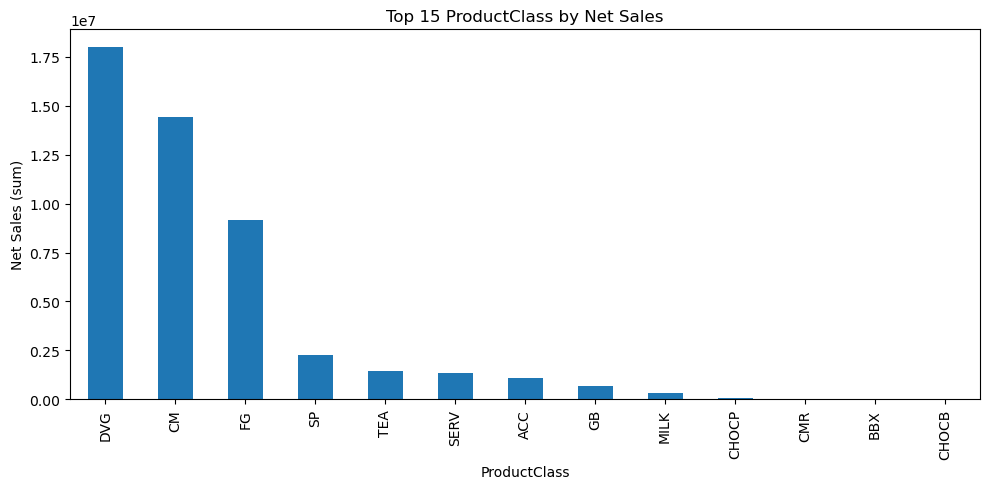

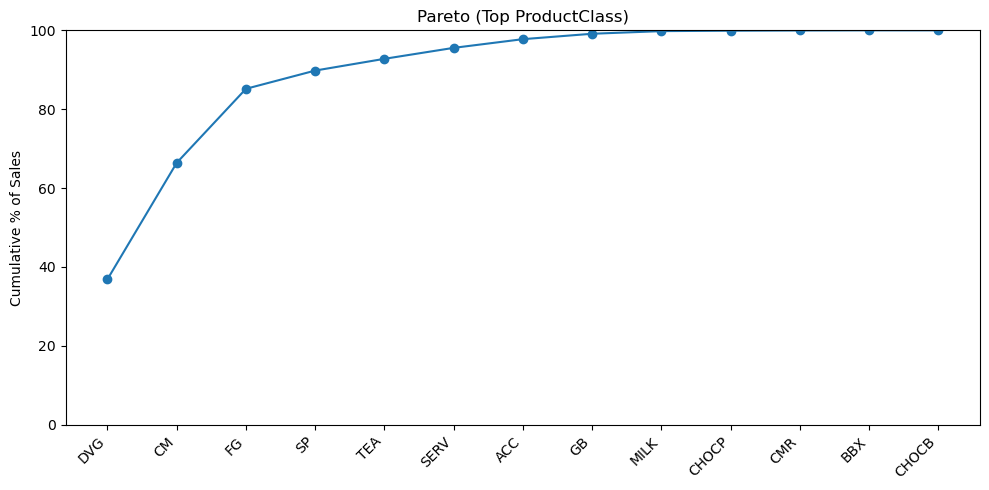

In [65]:
g = (base.assign(NetSalesValue=base['NetSalesValue'].clip(lower=0))
          .groupby('ProductClass', dropna=False)['NetSalesValue'].sum()
          .sort_values(ascending=False))

top = g.head(15)
ax = top.plot(kind='bar')
ax.set_title('Top 15 ProductClass by Net Sales')
ax.set_ylabel('Net Sales (sum)')
ax.set_xlabel('ProductClass')
plt.tight_layout()
plt.show()

# Optional: cumulative %
cum = (top.cumsum() / top.sum() * 100)
fig, ax = plt.subplots()
ax.plot(range(1, len(cum)+1), cum.values, marker='o')
ax.set_xticks(range(1, len(cum)+1))
ax.set_xticklabels(top.index, rotation=45, ha='right')
ax.set_ylim(0, 100)
ax.set_ylabel('Cumulative % of Sales')
ax.set_title('Pareto (Top ProductClass)')
plt.tight_layout()
plt.show()


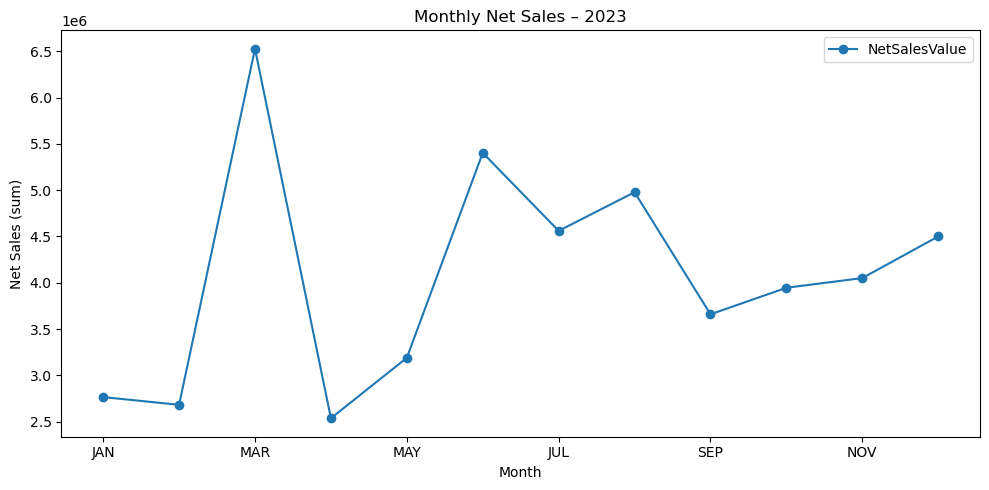

In [67]:
if {'Month','Year','NetSalesValue'}.issubset(base.columns):
    m = (base.assign(NetSalesValue=base['NetSalesValue'].clip(lower=0))
              .groupby(['Year','Month'], as_index=False)['NetSalesValue'].sum()
              .sort_values(['Year','Month']))
    m['MonthName'] = month_label(m['Month'])

    for yr, dfy in m.groupby('Year'):
        ax = dfy.sort_values('Month').plot(x='MonthName', y='NetSalesValue', marker='o')
        ax.set_title(f'Monthly Net Sales – {int(yr)}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Net Sales (sum)')
        plt.tight_layout()
        plt.show()


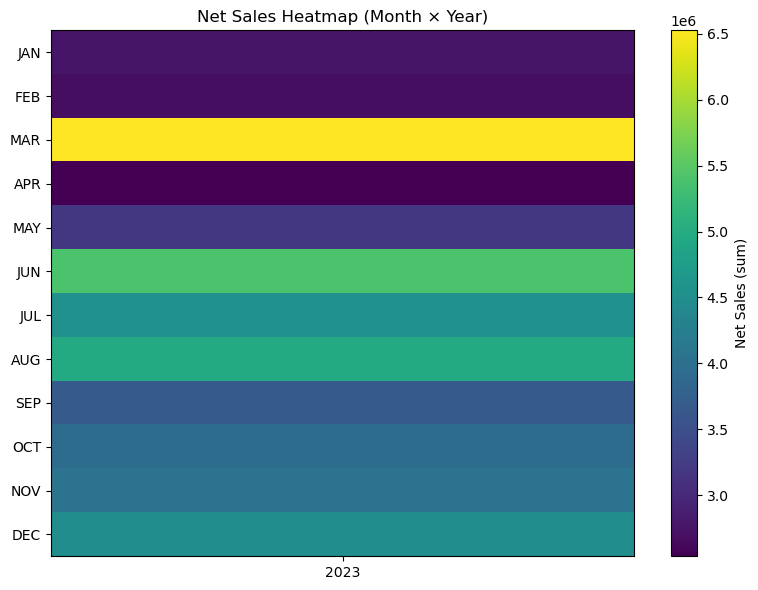

In [69]:
if {'Month','Year','NetSalesValue'}.issubset(base.columns):
    p = (base.assign(NetSalesValue=base['NetSalesValue'].clip(lower=0))
              .pivot_table(index='Month', columns='Year', values='NetSalesValue', aggfunc='sum', fill_value=0)
              .reindex(range(1,13)))
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(p.values, aspect='auto')
    ax.set_yticks(range(12)); ax.set_yticklabels([MONTHS[i] for i in range(1,13)])
    ax.set_xticks(range(len(p.columns))); ax.set_xticklabels(p.columns, rotation=0)
    ax.set_title('Net Sales Heatmap (Month × Year)')
    fig.colorbar(im, ax=ax, label='Net Sales (sum)')
    plt.tight_layout(); plt.show()


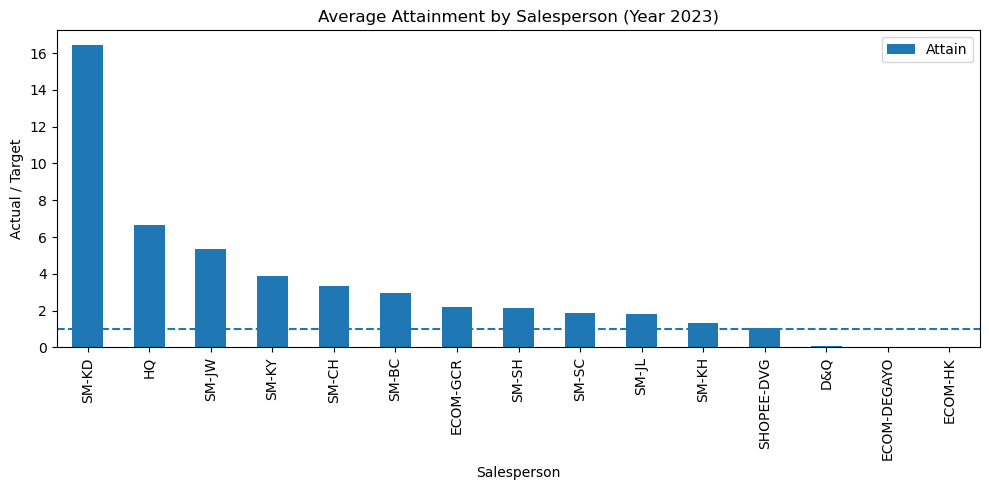

In [71]:
need = {'Salesperson','NetSalesValue','TargetSales','Month','Year'}
if need.issubset(base.columns):
    agg = (base.assign(NetSalesValue=base['NetSalesValue'].clip(lower=0))
                .groupby(['Salesperson','Year','Month'], as_index=False)
                .agg(Actual=('NetSalesValue','sum'), Target=('TargetSales','median')))
    # attainment (Actual / Target)
    agg['Attain'] = np.where(agg['Target']>0, agg['Actual']/agg['Target'], np.nan)

    # latest year only (if multiple)
    latest_year = int(agg['Year'].max())
    a = (agg[agg['Year']==latest_year]
         .groupby('Salesperson', as_index=False)['Attain'].mean()
         .sort_values('Attain', ascending=False).head(15))
    ax = a.plot(x='Salesperson', y='Attain', kind='bar')
    ax.axhline(1.0, linestyle='--')
    ax.set_title(f'Average Attainment by Salesperson (Year {latest_year})')
    ax.set_ylabel('Actual / Target')
    ax.set_xlabel('Salesperson')
    plt.tight_layout(); plt.show()


SM-KD transactions shape: (110, 11)

Target values summary:
count    110.000000
mean     454.940771
std      142.006784
min       35.000000
25%      433.818182
50%      433.818182
75%      433.818182
max      936.666667
Name: TargetSales, dtype: float64

Net Sales summary:
count      110.000000
mean       777.160455
std       1760.113129
min         32.000000
25%        101.512500
50%        210.000000
75%        500.000000
max      10620.000000
Name: NetSalesValue, dtype: float64

Monthly totals for SM-KD:
    Year  Month    Actual      Target     Attain
0   2023      1   2964.00  433.818182   6.832355
1   2023      2   1060.00  433.818182   2.443420
2   2023      3   3692.00  433.818182   8.510478
3   2023      4   1003.43  433.818182   2.313020
4   2023      5   3282.00  433.818182   7.565381
5   2023      6   5885.77  433.818182  13.567366
6   2023      7   1037.77  433.818182   2.392177
7   2023      8   1910.00  433.818182   4.402766
8   2023      9   3050.00  433.818182   7.0305

Text(0, 0.5, 'Sales')

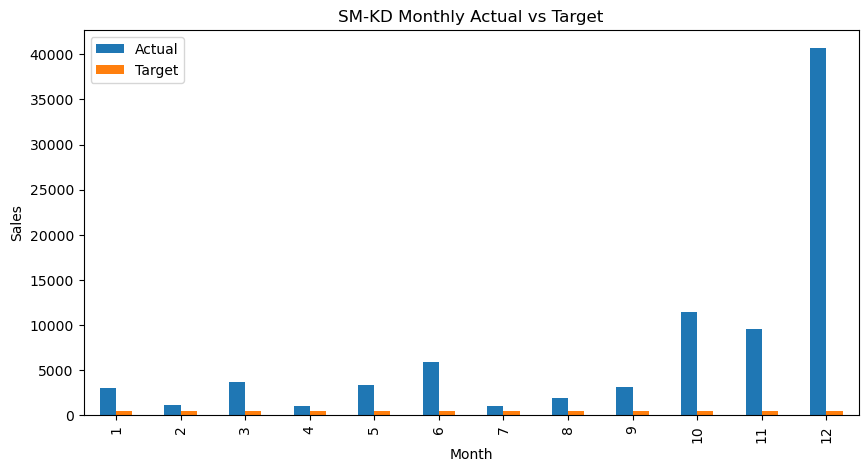

In [83]:
import pandas as pd

# Focus only on SM-KD
kd = base[base['Salesperson'] == 'SM-KD'].copy()

# --- 1) Quick summary
print("SM-KD transactions shape:", kd.shape)
print("\nTarget values summary:")
print(kd['TargetSales'].describe())

print("\nNet Sales summary:")
print(kd['NetSalesValue'].describe())

# --- 2) Monthly totals (Actual vs Target)
monthly = (kd.groupby(['Year','Month'], as_index=False)
             .agg(Actual=('NetSalesValue','sum'),
                  Target=('TargetSales','median')))  # target often constant per salesperson
monthly['Attain'] = monthly['Actual'] / monthly['Target']
print("\nMonthly totals for SM-KD:")
print(monthly)

# --- 3) Invoice-level anomalies
invoice = (kd.groupby('Invoice', as_index=False)
             .agg(Actual=('NetSalesValue','sum'),
                  Target=('TargetSales','median')))
invoice['Attain'] = invoice['Actual'] / invoice['Target']
big = invoice.sort_values('Attain', ascending=False).head(10)
print("\nTop invoices with highest Attainment:")
print(big)

# --- 4) Visualization
ax = monthly.plot(x='Month', y=['Actual','Target'], kind='bar')
ax.set_title('SM-KD Monthly Actual vs Target')
ax.set_ylabel('Sales')


    Salesperson   MedianTarget     MeanTarget  Count
11        SM-KD     433.818182     454.940771    110
4            HQ    1505.281818    1980.689129    450
2      ECOM-GCR    6315.718182    6158.971639   1036
8         SM-CH   13709.472730   14047.841905   1779
13        SM-KY   14432.820910   17046.209825   1911
6    SHOPEE-DVG   17933.316360   17933.316360   4080
7         SM-BC   22812.680000   18583.938610   2815
12        SM-KH   61681.822730   54135.820712   3568
1   ECOM-DEGAYO  139750.000000  139750.000000    118
3       ECOM-HK  139750.000000  139750.000000      7
     Salesperson  MedianTarget     MeanTarget  Count
7          SM-BC   22812.68000   18583.938610   2815
12         SM-KH   61681.82273   54135.820712   3568
1    ECOM-DEGAYO  139750.00000  139750.000000    118
3        ECOM-HK  139750.00000  139750.000000      7
0            D&Q  276849.20180  276849.201800     20
5   SHOPEE-CREMA  276849.20180  276849.201800      2
14         SM-SC  276849.20180  218392.567235 

Text(0, 0.5, 'Target Value')

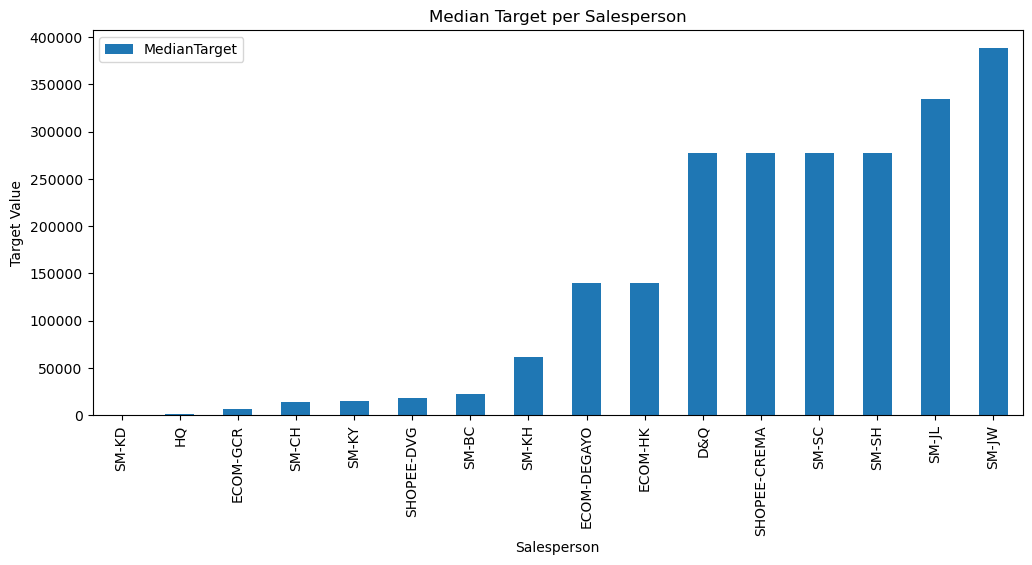

In [85]:
# Compare TargetSales across salespeople
target_check = (base.groupby('Salesperson', as_index=False)
                   .agg(MedianTarget=('TargetSales','median'),
                        MeanTarget=('TargetSales','mean'),
                        Count=('TargetSales','size')))
target_check = target_check.sort_values('MedianTarget')

print(target_check.head(10))  # lowest targets
print(target_check.tail(10))  # highest targets

# Visualize
ax = target_check.plot(x='Salesperson', y='MedianTarget', kind='bar', figsize=(12,5))
ax.set_title('Median Target per Salesperson')
ax.set_ylabel('Target Value')


In [87]:
# Option 1: Normalize target to team median
overall_median_target = base.groupby('Salesperson')['TargetSales'].median().median()

base['AdjAttain'] = base['NetSalesValue'] / base['TargetSales']

# For very low targets (like <10% of overall median), replace with team median
base['NormTarget'] = base['TargetSales']
low_mask = base['TargetSales'] < (0.1 * overall_median_target)
base.loc[low_mask, 'NormTarget'] = overall_median_target

base['AdjAttain'] = base['NetSalesValue'] / base['NormTarget']

# Recompute average attainment per salesperson
adj = (base.groupby('Salesperson', as_index=False)
             .agg(AvgAdjAttain=('AdjAttain','mean')))
adj = adj.sort_values('AvgAdjAttain', ascending=False)
print(adj.head(10))


   Salesperson  AvgAdjAttain
0          D&Q      0.027807
8        SM-CH      0.018471
7        SM-BC      0.014183
13       SM-KY      0.010558
15       SM-SH      0.009138
11       SM-KD      0.007716
14       SM-SC      0.005952
12       SM-KH      0.005321
9        SM-JL      0.005082
10       SM-JW      0.004516


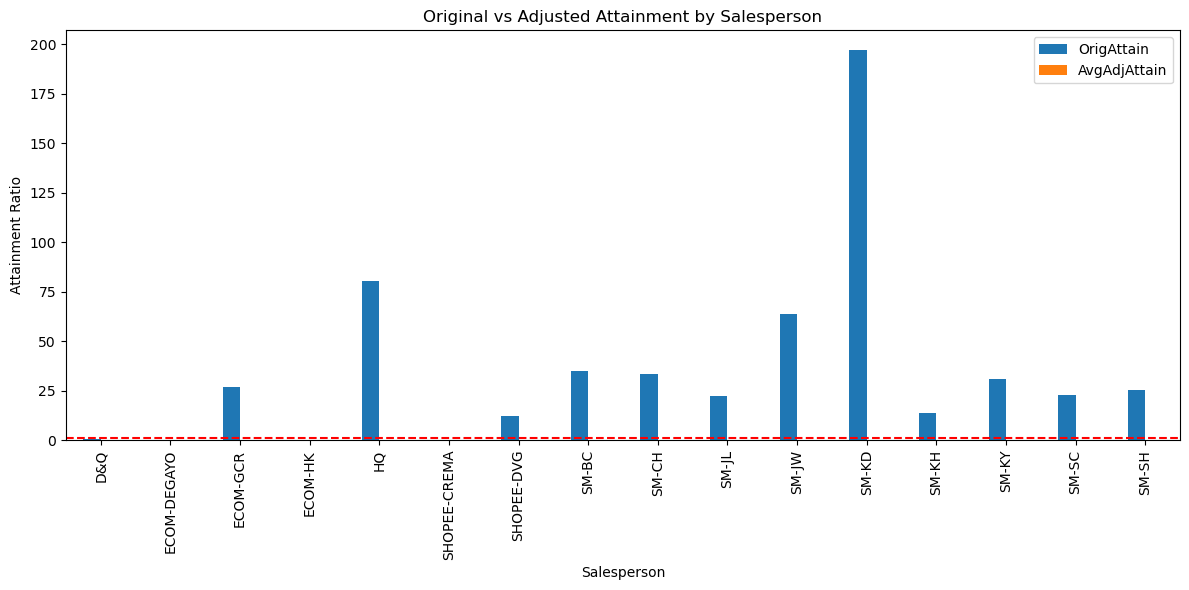

In [89]:
# Original attainment
orig = (base.groupby('Salesperson', as_index=False)
             .agg(OrigAttain=('NetSalesValue','sum'),
                  Target=('TargetSales','median')))
orig['OrigAttain'] = orig['OrigAttain'] / orig['Target']

# Merge with adjusted attainment
compare = orig[['Salesperson','OrigAttain']].merge(adj, on='Salesperson')

# Plot
compare.set_index('Salesperson').plot(kind='bar', figsize=(12,6))
plt.title("Original vs Adjusted Attainment by Salesperson")
plt.ylabel("Attainment Ratio")
plt.axhline(1, linestyle='--', color='red')
plt.tight_layout()
plt.show()


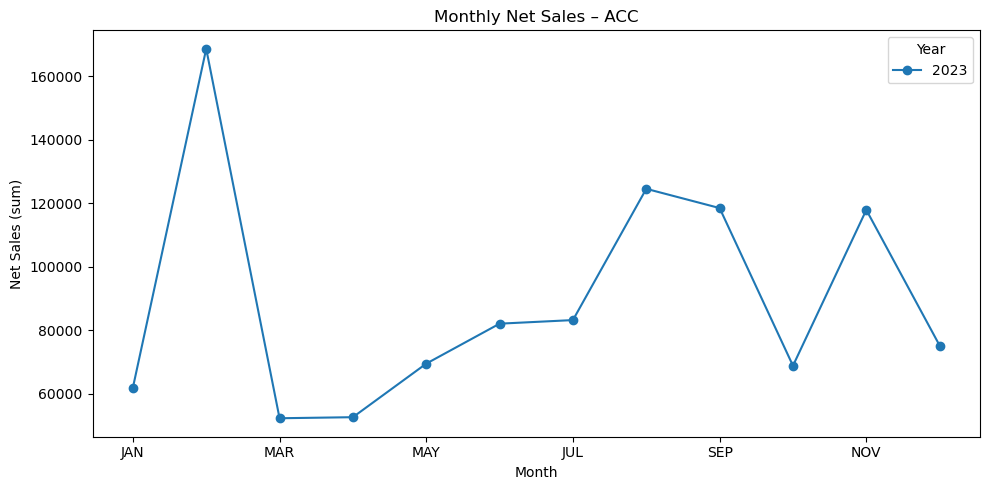

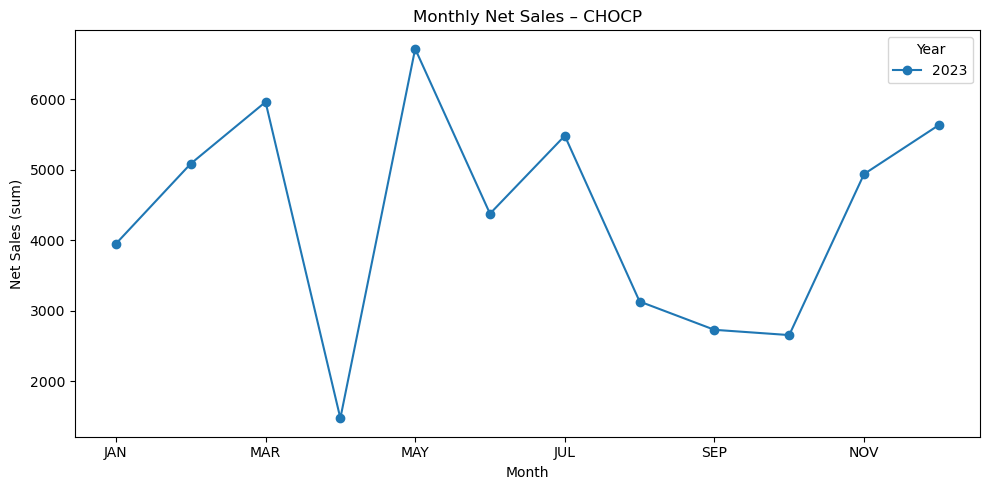

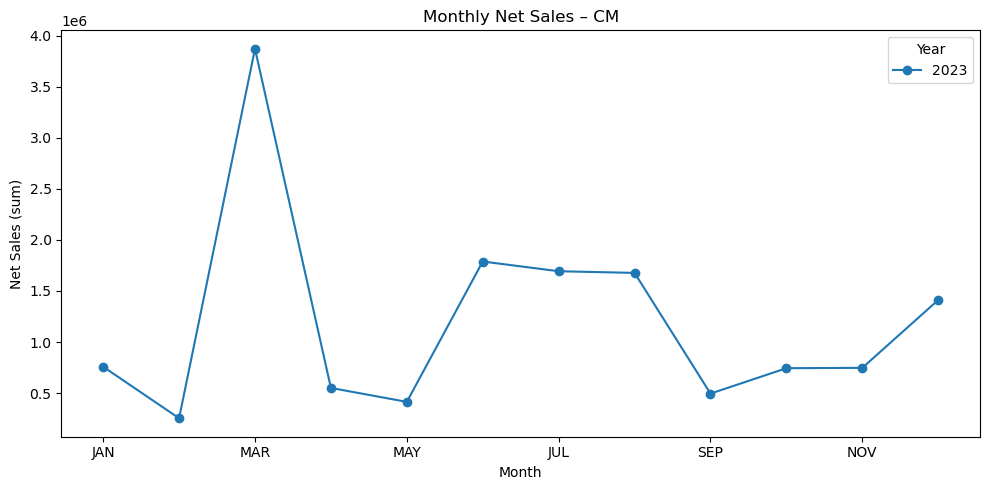

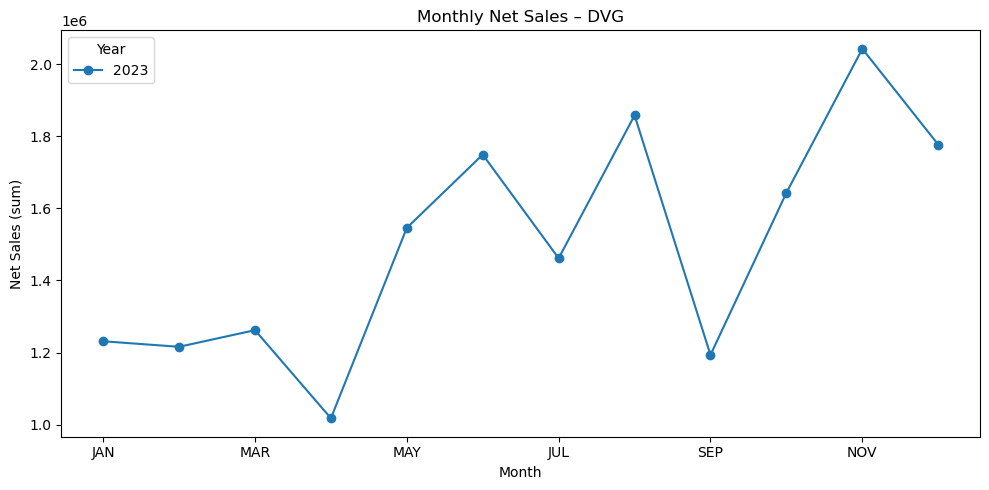

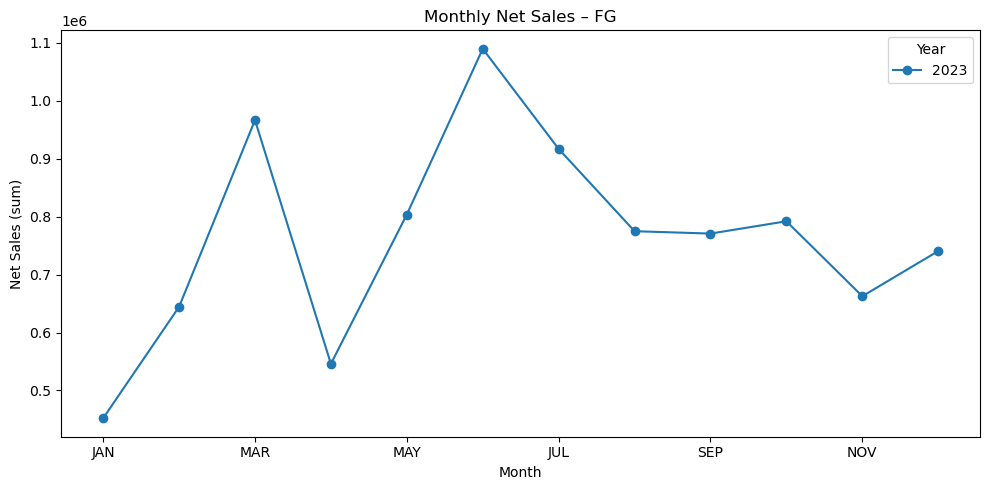

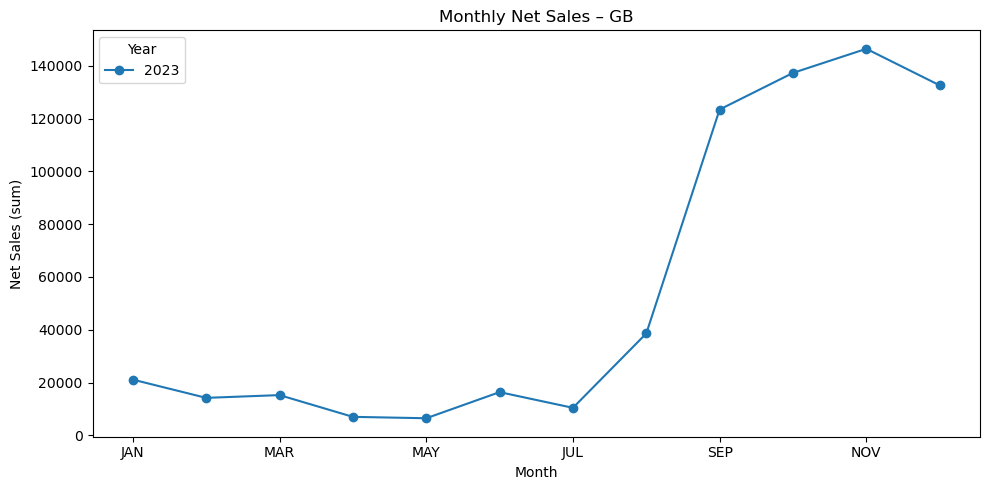

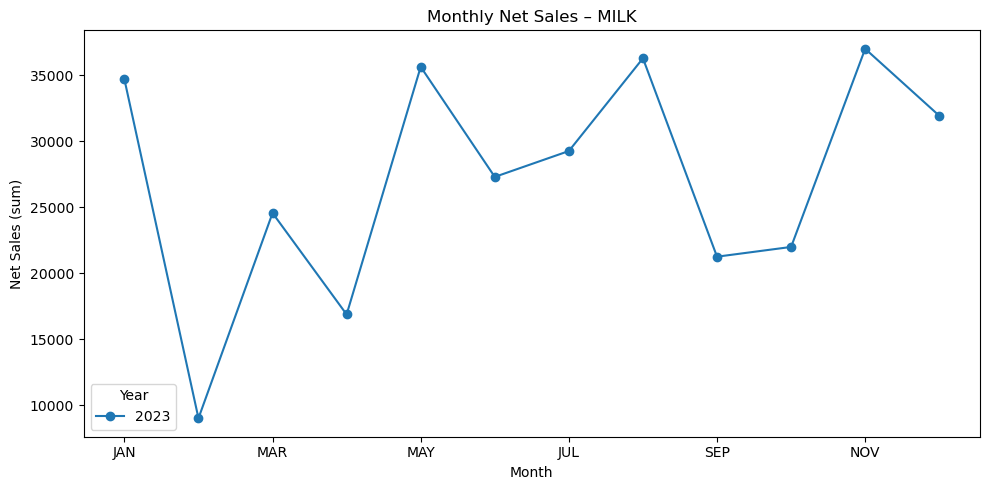

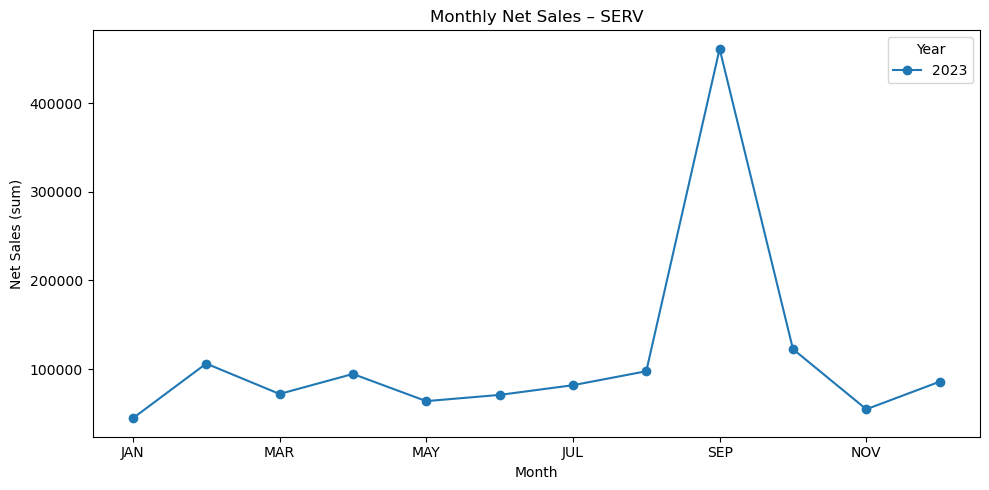

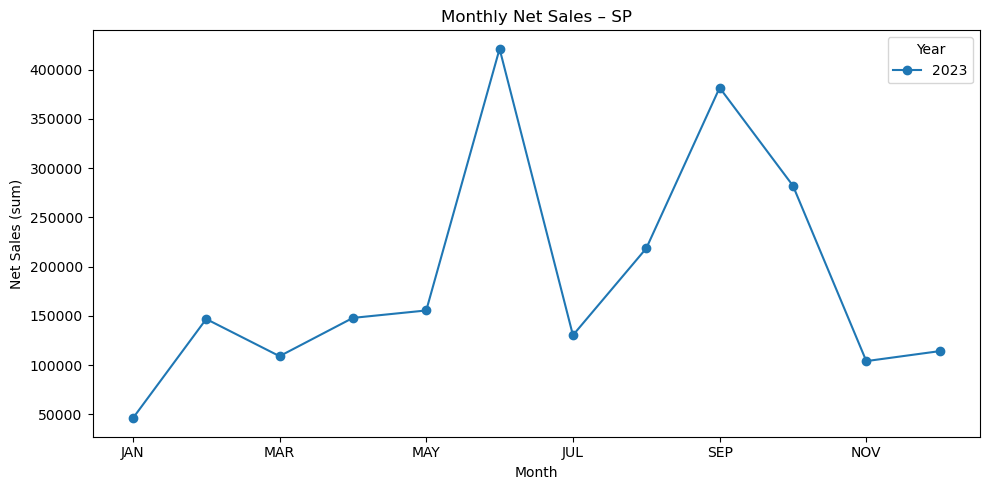

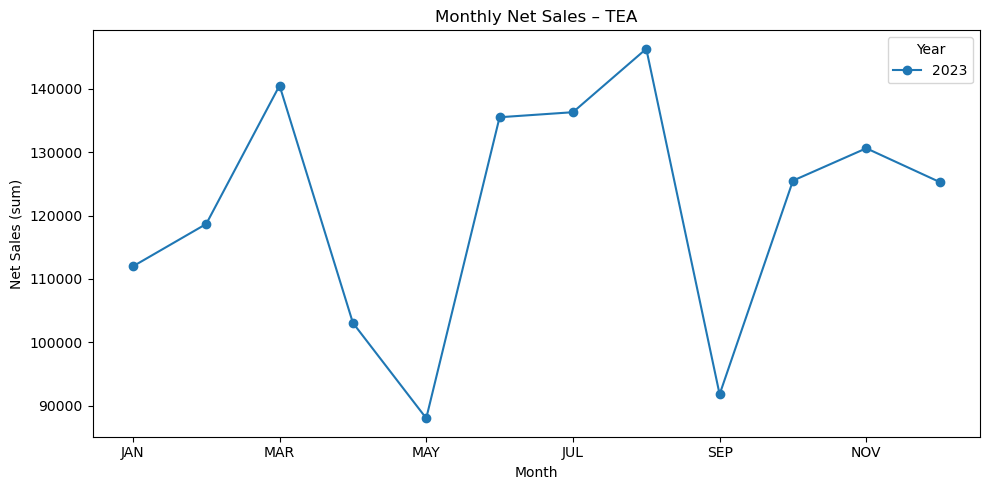

In [73]:
need = {'ProductClass','Month','Year','NetSalesValue'}
if need.issubset(base.columns):
    top_pc = (base.groupby('ProductClass')['NetSalesValue'].sum()
                   .sort_values(ascending=False).head(10).index.tolist())
    sub = base[base['ProductClass'].isin(top_pc)].copy()
    sub['MonthName'] = month_label(sub['Month'])

    for pc, dfp in sub.groupby('ProductClass'):
        s = (dfp.assign(NetSalesValue=dfp['NetSalesValue'].clip(lower=0))
                 .groupby(['Year','MonthName'], as_index=False)['NetSalesValue'].sum()
                 .sort_values(['Year','MonthName']))
        ax = s.pivot(index='MonthName', columns='Year', values='NetSalesValue').reindex(MONTHS.values()).plot(marker='o')
        ax.set_title(f'Monthly Net Sales – {pc}')
        ax.set_xlabel('Month'); ax.set_ylabel('Net Sales (sum)')
        plt.tight_layout(); plt.show()


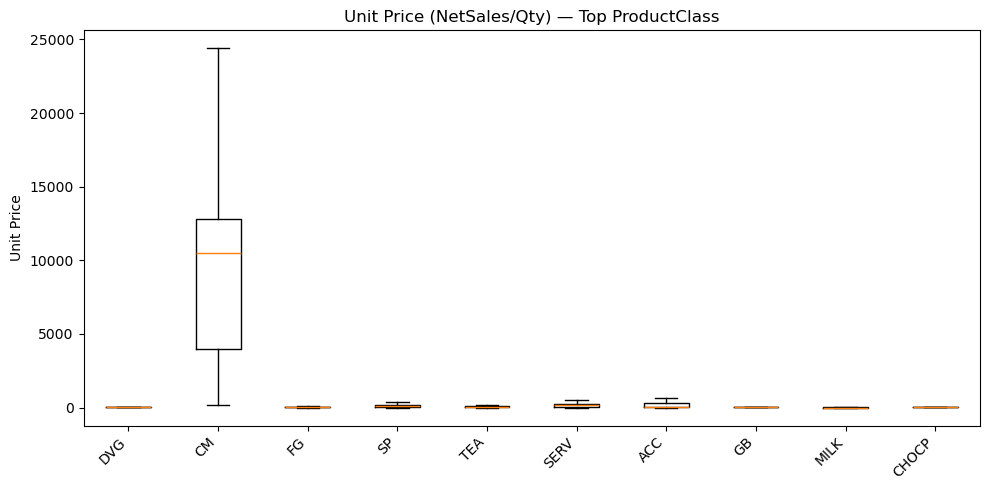

In [75]:
need = {'NetSalesValue','QtyInvoiced','ProductClass'}
if need.issubset(base.columns):
    dfu = base.copy()
    dfu['UnitPrice'] = np.where(dfu['QtyInvoiced']>0, dfu['NetSalesValue']/dfu['QtyInvoiced'], np.nan)
    top_pc = (dfu.groupby('ProductClass')['NetSalesValue'].sum()
                   .sort_values(ascending=False).head(10).index.tolist())
    dfu = dfu[dfu['ProductClass'].isin(top_pc) & dfu['UnitPrice'].notna()]

    # simple boxplot per class
    data = [dfu.loc[dfu['ProductClass']==pc, 'UnitPrice'].values for pc in top_pc]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.boxplot(data, showfliers=False)
    ax.set_xticklabels(top_pc, rotation=45, ha='right')
    ax.set_title('Unit Price (NetSales/Qty) — Top ProductClass')
    ax.set_ylabel('Unit Price')
    plt.tight_layout(); plt.show()


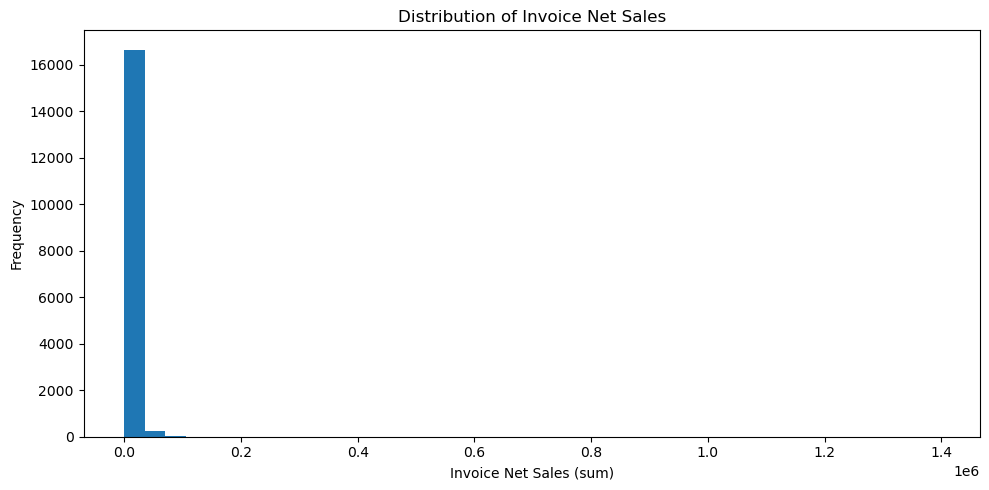

In [77]:
need = {'Invoice','NetSalesValue'}
if need.issubset(base.columns):
    inv = (base.assign(NetSalesValue=base['NetSalesValue'].clip(lower=0))
                .groupby('Invoice', as_index=False)['NetSalesValue'].sum())
    ax = inv['NetSalesValue'].plot(kind='hist', bins=40)
    ax.set_title('Distribution of Invoice Net Sales')
    ax.set_xlabel('Invoice Net Sales (sum)')
    plt.tight_layout(); plt.show()


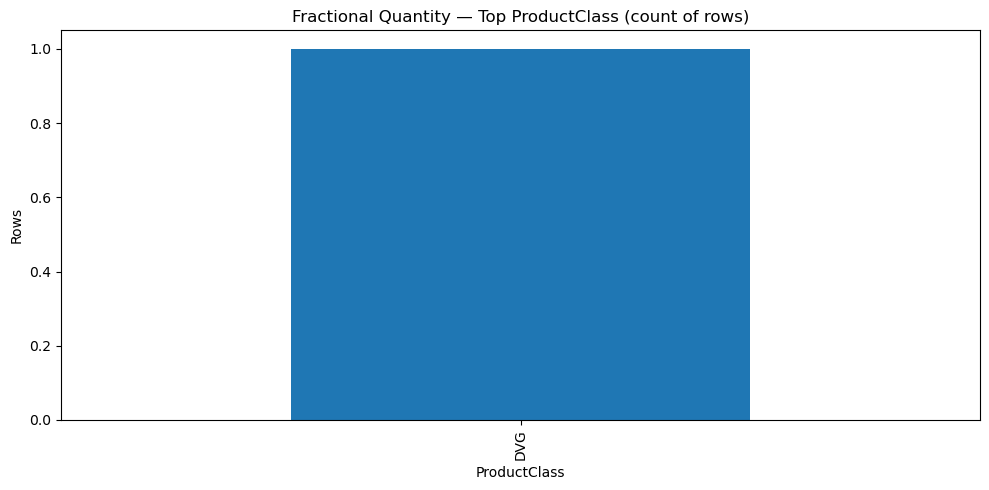

In [79]:
need = {'QtyInvoiced','ProductClass'}
if need.issubset(base.columns):
    frac = base[~np.isclose(base['QtyInvoiced'] % 1, 0)]
    if len(frac):
        ct = (frac.groupby('ProductClass')['QtyInvoiced']
                   .size().sort_values(ascending=False).head(15))
        ax = ct.plot(kind='bar')
        ax.set_title('Fractional Quantity — Top ProductClass (count of rows)')
        ax.set_ylabel('Rows')
        plt.tight_layout(); plt.show()
    else:
        print("No fractional quantities found.")


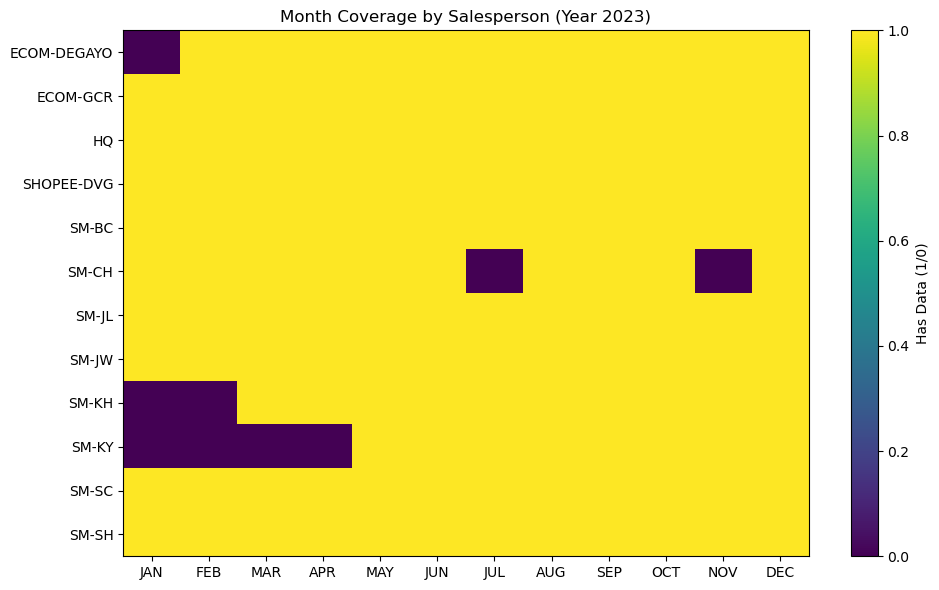

In [81]:
need = {'Salesperson','Year','Month'}
if need.issubset(base.columns):
    cov = (base.groupby(['Salesperson','Year','Month'])
                 .size().reset_index(name='Rows'))
    # pick latest year to keep it readable
    latest_year = int(cov['Year'].max())
    cov = cov[cov['Year'] == latest_year]

    # top 12 salespersons by activity
    top_sp = (cov.groupby('Salesperson')['Rows'].sum()
                   .sort_values(ascending=False).head(12).index.tolist())
    cov = cov[cov['Salesperson'].isin(top_sp)]

    pv = (cov.assign(has=1)
              .pivot_table(index='Salesperson', columns='Month', values='has', aggfunc='max', fill_value=0)
              .reindex(columns=range(1,13)))

    fig, ax = plt.subplots(figsize=(10,6))
    im = ax.imshow(pv.values, aspect='auto')
    ax.set_xticks(range(12)); ax.set_xticklabels([MONTHS[i] for i in range(1,13)], rotation=0)
    ax.set_yticks(range(len(pv.index))); ax.set_yticklabels(pv.index)
    ax.set_title(f'Month Coverage by Salesperson (Year {latest_year})')
    fig.colorbar(im, ax=ax, label='Has Data (1/0)')
    plt.tight_layout(); plt.show()
